In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [4]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [83]:
import numpy as np
def whiten(X, method='zca'):
    """
    https://gist.github.com/joelouismarino/ce239b5601fff2698895f48003f7464b
    Whitens the input matrix X using specified whitening method.
    Inputs:
        X:      Input data matrix with data examples along the first dimension
        method: Whitening method. Must be one of 'zca', 'zca_cor', 'pca',
                'pca_cor', or 'cholesky'.
    """
    X = X.reshape((-1, np.prod(X.shape[1:])))
    X_centered = X - np.mean(X, axis=0)
    Sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    W = None
    if method in ['zca', 'pca', 'cholesky']:
        U, Lambda, _ = np.linalg.svd(Sigma)
    if method == 'zca':
        W = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-2)), U.T))
    elif method =='pca':
        W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T)
    elif method == 'cholesky':
        W = np.linalg.cholesky(np.dot(U, np.dot(np.diag(1.0 / (Lambda + 1e-5)), U.T))).T
    elif method in ['zca_cor', 'pca_cor']:
        V_sqrt = np.diag(np.std(X, axis=0))
        P = np.dot(np.dot(np.linalg.inv(V_sqrt), Sigma), np.linalg.inv(V_sqrt))
        G, Theta, _ = np.linalg.svd(P)
    if method == 'zca_cor':
        W = np.dot(np.dot(G, np.dot(np.diag(1.0 / np.sqrt(Theta + 1e-5)), G.T)), V_sqrt)
    elif method == 'pca_cor':
        W = np.dot(np.dot(np.diag(1.0/np.sqrt(Theta + 1e-5)), G.T), V_sqrt)
    return np.dot(X_centered, W.T)

In [125]:
#https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col = image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

      # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [126]:
def draw_shape(image, shape, dims):
    """Draws a shape from the given specs."""
    # Get the center x, y and the size s
    x, y, s = dims
    if shape == 'square':
        cv2.rectangle(image, (x, y), (x+s, y+s), -1)
    elif shape == "circle":
        cv2.circle(image, (x, y), s, -1)
    elif shape == "triangle":
        x=random.randint(0,100)
        y=random.randint(0,100)
        s=random.randint(0,100)
        cv2.line(image,(x,y),(y,s),-1)
        cv2.line(image,(y,s),(s,x),-1)
        cv2.line(image,(s,x),(x,y),-1)
    elif shape == "plus":
        s=random.randint(5,min(100-x,100-y,2*y))
        cv2.line(image,(x,y),(x+s,y),-1)
        cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)
    elif shape == "dot":
        s=random.randint(1,5)
        cv2.circle(image, (x, y), s,(0,0,255), -1)
    elif shape == "curve":
        a=random.randint(1,5)*0.1
        b=random.randint(5,50)
        c=random.randint(0,100-2*b)
        x=np.arange(100)
        y=np.sin(a*x)
        pts=[]
        if random.randint(1,2)==1:
            for i in range (0,100):
                pts.append([x[i],int(b*y[i]+b+c)])
        else:
            for i in range (0,100):
                pts.append([int(b*y[i]+b+c),x[i]])
        line_width=random.randint(1,3)
        cv2.polylines(image, [np.array(pts)], False, (0,0,255),thickness=line_width, lineType=cv2.LINE_8)
    elif shape == "line":
        s=random.randint(5,min(100-x,100-y,2*y))
        if random.randint(1,2)==1:
            cv2.line(image,(x,y),(x+s,y),-1)
        else:
            cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)        
    return noisy("gauss", whiten(image, method='zca'))

In [127]:
width=100
highth=100
x=random.randint(5,width-5)
y=random.randint(5,highth-5)
s=random.randint(5,np.minimum(width-x,highth-y))
dims=[x,y,s]
image = np.ones([highth,width])
draw_shape(image, 'circle',dims)


array([[ 4.05657916e-01,  1.87922380e-01,  3.45130523e-01, ...,
         6.56182861e-01,  1.52135838e-01, -7.50449986e-02],
       [ 2.00697111e-02, -3.89432876e-01,  6.88211286e-01, ...,
         9.74819350e-02, -6.79324368e-04,  1.19331414e-01],
       [-1.67320172e-01, -3.11828974e-01, -1.45787164e-01, ...,
         3.03719543e-02, -2.26829277e-01,  1.27938833e-01],
       ...,
       [ 6.55366866e-01,  1.21404015e-01,  1.34077392e-01, ...,
         1.08331781e-01,  8.24612504e-02, -7.60794698e-01],
       [ 3.37037626e-01,  1.00324383e-01, -4.24894953e-01, ...,
         5.09450864e-01,  2.01377732e-01,  3.32080471e-01],
       [ 2.22412718e-01,  2.30212621e-01,  1.66591342e-02, ...,
        -2.38399305e-01, -1.69028928e-01,  2.67301597e-01]])

(-0.5, 99.5, 99.5, -0.5)

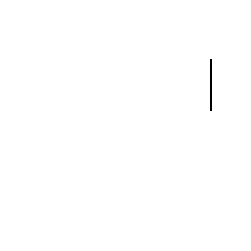

In [128]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
width=100
highth=100
x=random.randint(5,width-5)
y=random.randint(5,highth-5)
s=random.randint(5,np.minimum(width-x,highth-y))
dims=[x,y,s]
image = np.ones([highth,width])
shape = random.choice(["square", "circle", "triangle", "line", "curve", "dot", "plus"])
draw_shape(image,shape, dims)
plt.imshow(image,cmap='gray')
plt.axis('off')

In [16]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [62]:
# class ShapesDataset(utils.Dataset):
#     """Generates the shapes synthetic dataset. The dataset consists of simple
#     shapes (triangles, squares, circles) placed randomly on a blank surface.
#     The images are generated on the fly. No file access required.
#     """

#     def load_shapes(self, count, heighth, width):
#         """Generate the requested number of synthetic images.
#         count: number of images to generate.
#         height, width: the size of the generated images.
#         """
#         # Add classes
#         self.add_class("shapes", 1, "square")
#         self.add_class("shapes", 2, "circle")
#         self.add_class("shapes", 3, "triangle")
#         self.add_class("shapes", 4, "plus")
#         self.add_class("shapes", 5, "dot")
#         self.add_class("shapes", 6, "curve")  
#         self.add_class("shapes", 7, "line") 
        
#         for i in range(count):
#             shapes = self.random_image(heighth, width)
#             self.add_image("shapes", image_id=i, path=None,
#                    width=width, heighth=heighth, shapes=shapes)
#     def load_image(self, image_id):
#         """Generate an image from the specs of the given image ID.
#         Typically this function loads the image from a file, but
#         in this case it generates the image on the fly from the
#         specs in image_info.
#         """
#         info = self.image_info[image_id]
#         image = np.ones([info['heighth'], info['width'], 3], dtype=np.uint8)
#         for shape, dims in info['shapes']:
#             image = self.draw_shape(image, shape, dims)
#         return image
#     def image_reference(self, image_id):
#         """Return the shapes data of the image."""
#         info = self.image_info[image_id]
#         if info["source"] == "shapes":
#             return info["shapes"]
#         else:
#             super(self.__class__).image_reference(self, image_id)
#     def load_mask(self, image_id):
#         """Generate instance masks for shapes of the given image ID.
#         """
#         info = self.image_info[image_id]
#         shapes = info['shapes']
#         count = len(shapes)
#         mask = np.zeros([info['heighth'], info['width'], count], dtype=np.uint8)
#         for i, (shape, dims) in enumerate(info['shapes']):
#             mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
#                                                 shape, dims)
#         #for i, (shape, dims) in enumerate(info['shapes']):
#         #    mask[:, :] = self.draw_shape(mask[:, :].copy(),
#         #                                        shape, dims)  
#         # Handle occlusions
#         occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
#         for i in range(count-2, -1, -1):
#             mask[:, :, i] = mask[:, :, i] * occlusion
#             occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
#         # Map class names to class IDs.
#         class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
#         return mask.astype(np.bool), class_ids.astype(np.int32)
#     def draw_shape(self, image, shape, dims):
#         """Draws a shape from the given specs."""
#         # Get the center x, y and the size s
#         x, y, s = dims
#         if shape == 'square':
#             x=random.randint(5,width-5)
#             y=random.randint(5,highth-5)
#             s=random.randint(5,np.minimum(width-x,highth-y))
#             cv2.rectangle(image, (x, y), (x+s, y+s), -1)
#         elif shape == "circle":
#             x=random.randint(5,width-5)
#             y=random.randint(5,highth-5)
#             s=random.randint(5,np.minimum(width-x,highth-y))
#             cv2.circle(image, (x, y), s, -1)
#         elif shape == "triangle":
#             x=random.randint(0,width)
#             y=random.randint(0,highth)
#             s=random.randint(0,width)
#             cv2.line(image,(x,y),(y,s),-1)
#             cv2.line(image,(y,s),(s,x),-1)
#             cv2.line(image,(s,x),(x,y),-1)
#         elif shape == "plus":
#             x=random.randint(5,width-5)
#             y=random.randint(5,highth-5)
#             s=random.randint(5,min(width-x,highth-y,2*y))
#             cv2.line(image,(x,y),(x+s,y),-1)
#             cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)
#         elif shape == "dot":
#             x=random.randint(5,width-5)
#             y=random.randint(5,highth-5)
#             s=random.randint(5,np.minimum(width-x,highth-y))
#             s=random.randint(1,5)
#             cv2.circle(image, (x, y), s,(0,0,255), -1)
#         elif shape == "curve":
#             a=random.randint(1,5)*0.1
#             b=random.randint(5,width/2)
#             c=random.randint(0,width-2*b)
#             x=np.arange(width)
#             y=np.sin(a*x)
#             pts=[]
#             if random.randint(1,2)==1:
#                 for i in range (0,width):
#                     pts.append([x[i],int(b*y[i]+b+c)])
#             else:
#                 for i in range (0,highth):
#                     pts.append([int(b*y[i]+b+c),x[i]])
#             line_width=random.randint(1,3)
#             cv2.polylines(image, [np.array(pts)], False, (0,0,255),thickness=line_width, lineType=cv2.LINE_8)
#         elif shape == "line":
#             x=random.randint(5,width-5)
#             y=random.randint(5,highth-5)
#             s=random.randint(5,min(width-x,highth-y,2*y))
#             if random.randint(1,2)==1:
#                 cv2.line(image,(x,y),(x+s,y),-1)
#             else:
#                 cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)        
#         return image
#     def random_shape(self, height, width):
#         """Generates specifications of a random shape that lies within
#         the given height and width boundaries.
#         Returns a tuple of three valus:
#         * The shape name (square, circle, ...)
#         * Shape color: a tuple of 3 values, RGB.
#         * Shape dimensions: A tuple of values that define the shape size
#                             and location. Differs per shape type.
#         """
#         # Shape
#         shape = random.choice(["square", "circle", "triangle", "line", "curve", "dot", "plus"])
#         # Color
#         # Center x, y
#         x=random.randint(5,width-5)
#         y=random.randint(5,highth-5)
#         s=random.randint(5,np.minimum(width-x,highth-y))
#         return shape, (x, y, s)
#     def random_image(self, height, width):
#         """Creates random specifications of an image with multiple shapes.
#         Returns the background color of the image and a list of shape
#         specifications that can be used to draw the image.
#         """
#         # Pick random background color
#         #bg_color = np.array([random.randint(0, 255) for _ in range(3)])
#         # Generate a few random shapes and record their
#         # bounding boxes
#         shapes = []
#         boxes = []
#         N = random.randint(1, 4)
#         for _ in range(N):
#             shape, dims = self.random_shape(height, width)
#             shapes.append((shape, dims))
#             x, y, s = dims
#             boxes.append([y-s, x-s, y+s, x+s])
#         # Apply non-max suppression wit 0.3 threshold to avoid
#         # shapes covering each other
#         keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
#         shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
#         return shapes

In [17]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, heighth, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "plus")
        self.add_class("shapes", 5, "dot")
        self.add_class("shapes", 6, "curve")  
        self.add_class("shapes", 7, "line") 
        
        for i in range(count):
            shapes = self.random_image(heighth, width)
            self.add_image("shapes", image_id=i, path=None,
                   width=width, heighth=heighth, shapes=shapes)
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = np.ones([info['heighth'], info['width'], 3], dtype=np.uint8)
        for shape, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims)
        return image
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        #print(info['shapes'])
        shapes = info['shapes']
        count = len(shapes)
        mask = np.ones([info['heighth'], info['width'], count], dtype=np.uint8)
        for i, (shape, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims)
        #for i, (shape, dims) in enumerate(info['shapes']):
        #    mask[:, :] = self.draw_shape(mask[:, :].copy(),
        #                                        shape, dims)  
        # Handle occlusions
        #occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        #for i in range(count-2, -1, -1):
        #    mask[:, :, i] = mask[:, :, i] * occlusion
        #    occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
        return mask, class_ids.astype(np.int32)
    def draw_shape(self, image, shape, dims):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x, y), (x+s, y+s), -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, -1)
        elif shape == "triangle":
            cv2.line(image,(x,y),(y,s),-1)
            cv2.line(image,(y,s),(s,x),-1)
            cv2.line(image,(s,x),(x,y),-1)
        elif shape == "plus":
            cv2.line(image,(x,y),(x+s,y),-1)
            cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)
        elif shape == "dot":
            cv2.circle(image, (x, y), s,(0,0,255), -1)
        elif shape == "curve":
            a=np.arange(width)
            b=np.sin(a*x)
            pts=[]
            if random.randint(1,2)==1:
                for i in range (0,width):
                    pts.append([a[i],int(y*b[i]+y+s)])
            else:
                for i in range (0,highth):
                    pts.append([int(y*b[i]+y+s),a[i]])
            line_width=random.randint(1,3)
            cv2.polylines(image, [np.array(pts)], False, (0,0,255),thickness=line_width, lineType=cv2.LINE_8)
        elif shape == "line":
            if random.randint(1,2)==1:
                cv2.line(image,(x,y),(x+s,y),-1)
            else:
                cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)        
        return image
    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle", "line", "curve", "dot", "plus"])
        # Color
        # Center x, y
        x=random.randint(5,width-5)
        y=random.randint(5,highth-5)
        s=random.randint(5,np.minimum(width-x,highth-y))
        if shape == "dot":
            s=random.randint(1,5)
        elif shape == "curve":
            x=random.randint(1,5)*0.1
            y=random.randint(5,width/2)
            s=random.randint(0,width-2*y)
        return shape, (x, y, s)
    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        #bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, dims = self.random_shape(height, width)
            shapes.append((shape, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return shapes

In [9]:
e=[('dot', (79, 47, 4)), ('curve', (0.2, 42, 6))]
mask = np.ones([128, 128, 2], dtype=np.uint8)
for i in range (1,len(e)):
    mask[:, :, i:i+1] = draw_shape(mask[:, :, i:i+1].copy(),
                                                    e[i][0], e[i][1])
mask[mask!=1]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.])

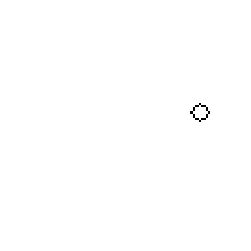

In [33]:
width=100
highth=100
dims=[79, 47, 4]
image = np.ones([highth,width])
shape = 'circle'
draw_shape(image,shape, dims)
plt.imshow(image,cmap='gray')
plt.axis('off')
image[image!=1]

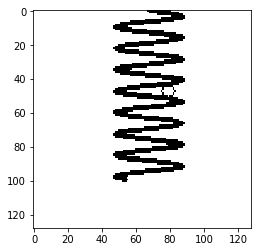

In [10]:
a=draw_shape(mask[:, :, i:i+1].copy(),'circle', [79, 47, 4])
plt.imshow(a[:,:,0],cmap='gray')

In [129]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [20]:
dataset_val.num_images

50

In [12]:
dataset_train.load_image(1).shape

(128, 128, 3)

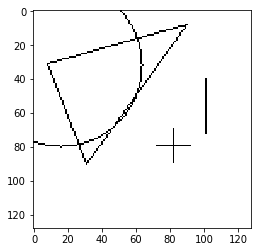

In [13]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    plt.imshow(dataset_train.load_image(0)[:,:,0],cmap='gray')
    #visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [14]:
mask.shape

(128, 128, 4)

In [15]:
mask, class_ids = dataset_train.load_mask(image_id)
mask[mask==True]

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

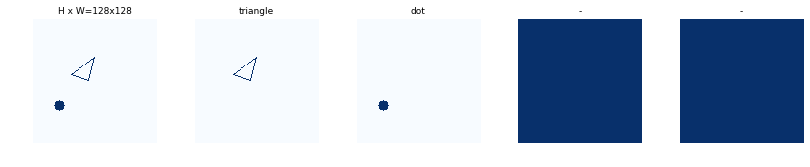

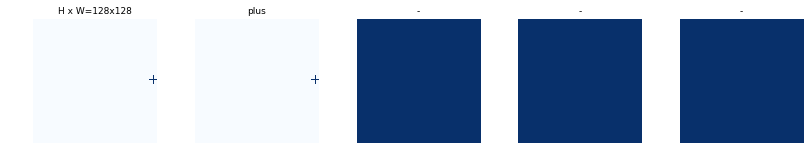

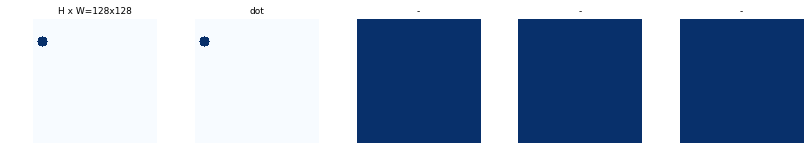

In [16]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image[:,:,0], mask, class_ids, dataset_train.class_names)

In [45]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
model = modellib.MaskRCNN(mode='training', config=config,
                          model_dir=MODEL_DIR)

In [46]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [27]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    #model.load_weights(model.find_last(), by_name=True)
    model.load_weights('/Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs/shapes20190516T1725/mask_rcnn_shapes_0002.h5')

Re-starting from epoch 2


In [28]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 2. LR=0.001

Checkpoint Path: /Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs/shapes20190516T1725/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (T

In [30]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=3, 
            layers="all")


Starting at epoch 2. LR=0.0001

Checkpoint Path: /Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs/shapes20190516T1725/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

In [5]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model.load_weights('/Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs/shapes20190516T1725/mask_rcnn_shapes_0002.h5', by_name=True)
# Load trained weights
#print("Loading weights from ", model_path)
#model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 2


In [52]:
gt_mask=np.logical_not(gt_mask).astype(np.bool)

In [12]:
pic.shape

(128, 128, 16)

In [21]:
def D():
    def load_shapes(self, count, heighth, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "plus")
        self.add_class("shapes", 5, "dot")
        self.add_class("shapes", 6, "curve")  
        self.add_class("shapes", 7, "line") 
        
        for i in range(count):
            if count < 16:
                shapes = pic[:,:,count-1]
            else:
                shapes = pic[:,:,random.randint(0,15)]
            self.add_image("shapes", image_id=i, path=None,
                   width=width, heighth=heighth, shapes=shapes)
    return shapes

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [29]:
p=[pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0],pic[:,:,0]]

In [33]:
model.config.BATCH_SIZE

1

In [131]:
dataset_train.load_image(11)

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

In [109]:
model.detect([dataset_train.load_image(11)])

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

In [46]:
b=np.load('b.npy')
for i in range(0,3):
    p[:,:,i]=b[:,:]
model.detect([p])

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

In [132]:
pic[pic==255]=1
pic[pic!=1]=0

In [137]:
pic=np.load('pic410.npy')
pic[pic!=255]
pic[pic>200]=1
pic[pic!=1]=0

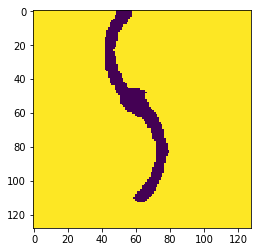

In [138]:
plt.imshow(pic[:,:,0])

In [139]:
#pic=np.load('pic410.npy')
p=np.zeros((128,128,3))
for n in range(0,3):
    for i in range(0,3):
        p[:,:,i]=pic[:,:,n]
    print(model.detect([p]))



[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(128, 128, 0), dtype=float64)}]
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(128, 128, 0), dtype=float64)}]
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(128, 128, 0), dtype=float64)}]


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (20,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (4,)                  min:    3.00000  max:    7.00000  int32
gt_bbox                  shape: (4, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 4)         min:    0.00000  max:    1.00000  uint8


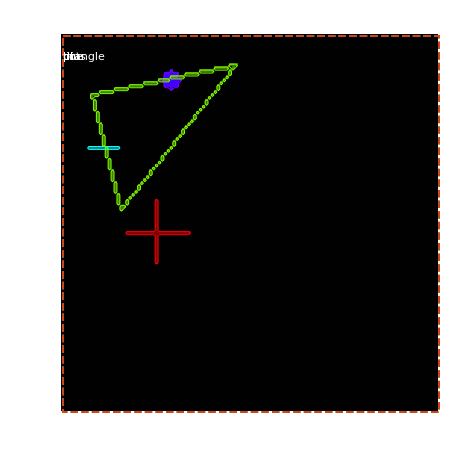

In [53]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
gt_mask=np.logical_not(gt_mask).astype(np.bool)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [56]:
np.where(gt_mask[:,:,0]!=0)

(array([12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
        15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18]),
 array([37, 35, 36, 37, 38, 39, 35, 36, 37, 38, 39, 34, 35, 36, 37, 38, 39,
        40, 35, 36, 37, 38, 39, 35, 36, 37, 38, 39, 37]))

In [41]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
